### Udacity Self-Driving Car Engineer Nanodegree


# Project 2: Advanced Lane Finding

**Input:** Video of a vehicle driving on a highway

**Output:** Annotated video with detected lane boudnaries, estimated lane curvature, and vehicle offset from center

     

<img src="./examples/example_output2.png" width=600 />

**Steps:**
* Camera calibration
* Distortionn correction
* Gradient and color thersholding
* Perspective transform to rectify the image
* Detecting lane pixels and fitting a polynomial 
* Detemining lane curvature and vehicle offset
* Warping detected lane boudaries back to the original image
* Visualizing lane boudaries and outputing lane curvature and vehicle offset



## Imports and Helper Functions

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

import enum


def show_image(image, bgr=False, gray=False):
    """
    Shows the image using matplotlib. 
    If the image is bgr, copies the image and converts 
    the color to rgb before showing
    """
    img = image
    if bgr and not gray:
        img = np.copy(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
        
    plt.show()
    

def show_images(im1, im2, title1=None, title2=None):
    """
    Shows two images side-by-side.
    """
    cmap = None
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    
    if len(im1.shape) == 2: cmap = "gray"
    ax1.imshow(im1, cmap=cmap)
    if title1: ax1.set_title(title1)

    if len(im2.shape) == 2: cmap = "gray"    
    ax2.imshow(im2, cmap=cmap)
    if title2: ax2.set_title(title2)

    plt.show()
    
    
def convert_to_gray(img, bgr=False):
    """
    Convert the input image to grayscale. 
    """
    if bgr: 
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else: 
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def convert_to_hls(img, bgr=False):
    """
    Converts the input image to HLS color space. 
    """
    if bgr: 
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else: 
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    
class CurveDirection(enum.Enum):
    LEFT = 0
    RIGHT = 1
    STRAIGHT_ROAD = 2


## Camera Calibration

In [2]:
def get_objpts(pattern_size):
    """
    Returns 3D object points for a given chessboard pattern size
    Pattern size must be a tuple (nx, ny)
    """
    nx, ny = pattern_size
    objpts = np.zeros((nx * ny, 3), np.float32)
    objpts[:, 0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    return objpts


def camera_calibration(images_path, pattern_size):
    """ Calculates and returns camera matrix and distoriton cooeffients. 

    This function take the path to a folder where images 
    of the calibaration chessboard pattern are stored. 
    The images must have a naming pattern as "calibrationX.jpg", 
    where X is consequitive number. 

    The function reads the images, detects the chessboard corners, 
    setups correspondence points resulting from all images, and 
    calculates and returns camera matrix and distortion coefficietns. 


    Args: 
        images_path: path to the folder where calibration images are stored.
        pattern_size: size of the chessboard pattern as tupple (x, y)

    Returns: 
        Camera matrix and distortion coefficients, or raises a 
        RuntimeExceptions if unsuccessful. 
    """
    
    objpts = get_objpts(pattern_size)
    img_points = []
    obj_points = []

    image_size = (0, 0)

    fnames = glob.glob(images_path)
    for i, fname in enumerate(fnames):
        img = cv2.imread(fname)
        image_size = img.shape[1::-1]
        ret, corners = cv2.findChessboardCorners(img, pattern_size, None)
        if ret:
            cv2.drawChessboardCorners(img, pattern_size, corners, ret)
            img_points.append(corners)
            obj_points.append(objpts)

    ret, mtx, dist, _, _ = cv2.calibrateCamera(obj_points, 
                                              img_points, 
                                              image_size, 
                                              None, 
                                              None)
    if ret:
        return mtx, dist
    else:
        raise RuntimeError("Could not calibrate camera")


images_path = "./camera_cal/calibration*.jpg"
pattern_size = (9, 6)
mtx, dist_coeff = camera_calibration(images_path, pattern_size)
print("Camera matrix: \n", mtx)
print()
print("Distortion coefficients: \n", dist_coeff)

Camera matrix: 
 [[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients: 
 [[-0.24688775 -0.02373132 -0.00109842  0.00035108 -0.00258571]]


## Distortion Correction

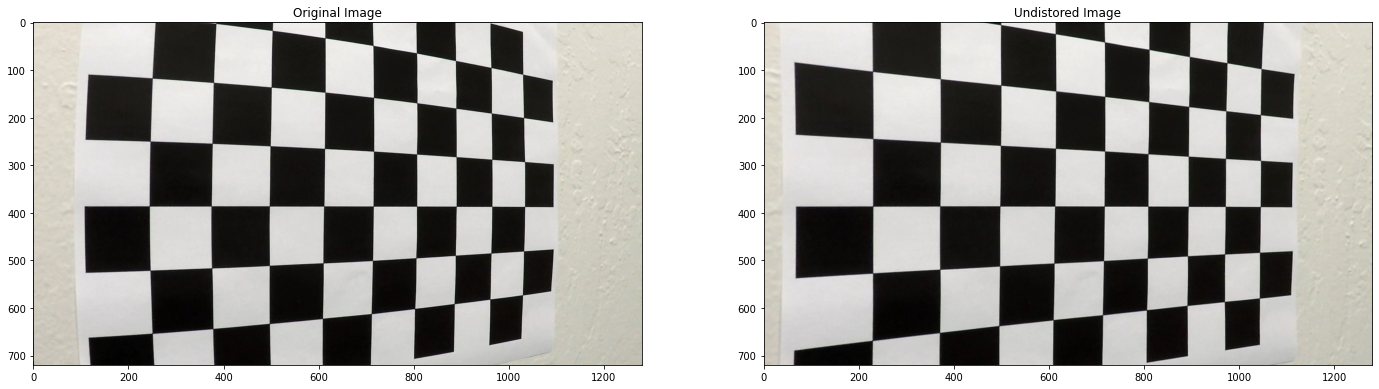

In [3]:
def correct_distortion(img, cam_matrix, dist_coeffs):
    """
    Corrects the image distortion and returns the undistored image.
    
    """
    return cv2.undistort(img, cam_matrix, dist_coeffs, None, cam_matrix)


image = plt.imread("./camera_cal/calibration5.jpg")
undistored = correct_distortion(image, mtx, dist_coeff)
show_images(image, undistored, "Original Image", "Undistored Image")



## Gradient and Color Thresholding

### Gradient Thresholding

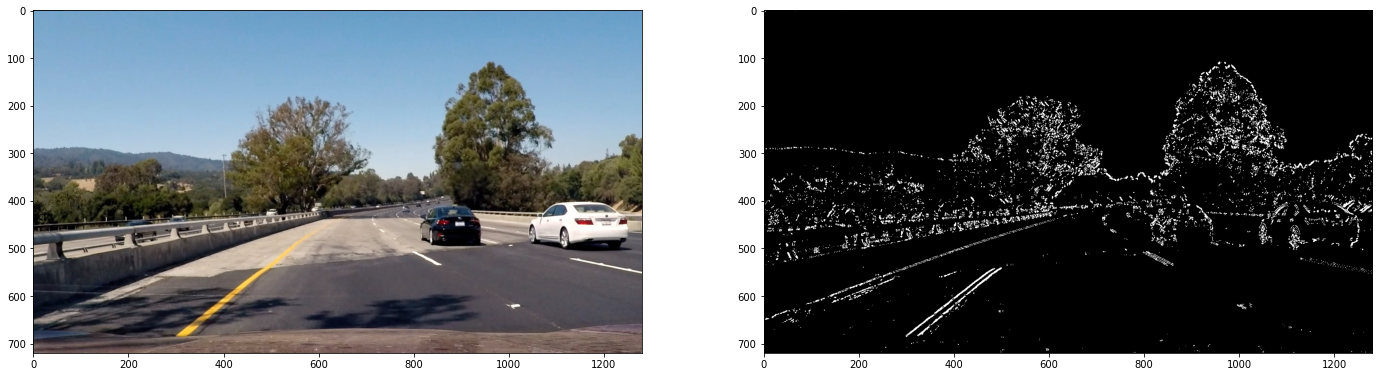

In [4]:
def abs_sobel_threshold(img, direction="x", thresh=(0, 255), ksize=3, bgr=False):
    """
    Applies the Sobel operator in the given direction and return 
    a binary image after applying the threshold. 
    """
    gray = convert_to_gray(img, bgr)
    s = None
    if direction=="x":
        s = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    else:  
        s = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
    abs_s = np.absolute(s)
    scaled_s = np.uint8(abs_s * 255 / np.max(abs_s))
    mask = np.zeros_like(gray)
    mask[(scaled_s >= thresh[0]) & (scaled_s <= thresh[1])] = 1
    return mask


def grad_mag_threshold(img, thresh=(0,255), ksize=3, bgr=False):
    """
    Applies Sobel operator to get the derivatives in x and y direction.
    Calculates the magnitude of the gradient for the input image, 
    applies the threshold, and returns the resulting binary image. 
    
    Args:
        img: the input image
        mag_thresh: the lower and upper threshold value for magnitude
                    of the gradient as a tuple (l, h)
        ksize: size of the Sobel kernel
        bgr: if the image is BGR format
        
    Returns: 
        Binary image, with 1 for every pixel with the magnitude of 
        gradient within threshold values.
    """
    gray = convert_to_gray(img, bgr) 
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    mag = np.sqrt(sx**2 + sy**2)
    mag_scaled = np.uint8(mag * 255 / np.max(mag))
    mask = np.zeros_like(gray)
    mask[(mag_scaled >= thresh[0]) & (mag_scaled <= thresh[1])] = 1
    return mask
    

def grad_dir_threshold(img, thresh=(-np.pi/2, np.pi/2), ksize=3, bgr=False):
    """
    Applies Sobel in x and y directions. Calculates the 
    direction of gradient. Applies the threshold and returns 
    the resulting binary image. 
    """
    gray = convert_to_gray(img, bgr)
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    abs_sx = np.absolute(sx)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    grad_dir = np.arctan2(sy, abs_sx)
    mask = np.zeros_like(gray)
    mask[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return mask


fnames = glob.glob("./test_images/*.jpg")
image = plt.imread(fnames[2])
sx_binary = abs_sobel_threshold(image, direction="x", thresh=(20, 120), ksize=5)
sy_binary = abs_sobel_threshold(image, direction="y", thresh=(20, 120), ksize=5)
mag_binary = grad_mag_threshold(image, thresh=(30, 100), ksize=7)
dir_binary = grad_dir_threshold(image, thresh=(0.2, 0.6), ksize=7)

combined_grad = np.zeros((image.shape[:2]), np.uint8)
combined_grad[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

show_images(image, combined_grad)

### Color Thresholding

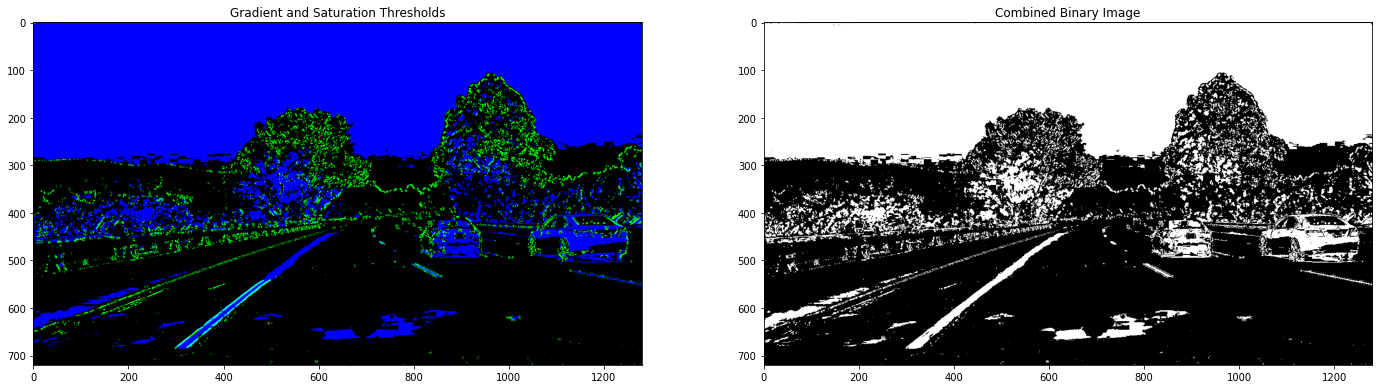

In [5]:
def saturation_threshold(img, thresh=(0, 255), bgr=False):
    """
    Converts the input image to HLS, applies the threshold
    to S channel, and reutrns the resulting binary image.
    """
    hls = convert_to_hls(image)
    s = hls[:, :, 2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return mask


def hue_threshold(img, thresh=(0, 255), bgr=False):
    """
    Converts the input image to HLS, applies the threshold
    to H channel, and reutrns the resulting binary image.
    
    Note: Not very useful. You better only use S channel
    """
    hls = convert_to_hls(image)
    h = hls[:, :, 0]
    mask = np.zeros_like(s)
    mask[(h >= thresh[0]) & (h <= thresh[1])] = 1
    return mask


sat_binary = saturation_threshold(image, (100, 255))

combined_binary = np.zeros_like(sat_binary)
combined_binary[(combined_grad == 1) | (sat_binary == 1)] = 1

combined_color = np.dstack((np.zeros_like(combined_grad), combined_grad, sat_binary)) * 255

show_images(combined_color, combined_binary, "Gradient and Saturation Thresholds", "Combined Binary Image")



## Perspective Transformation (rectify image)

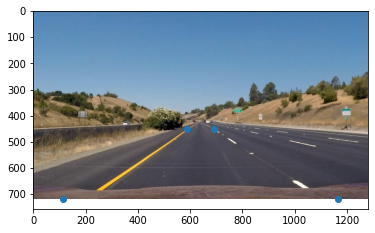

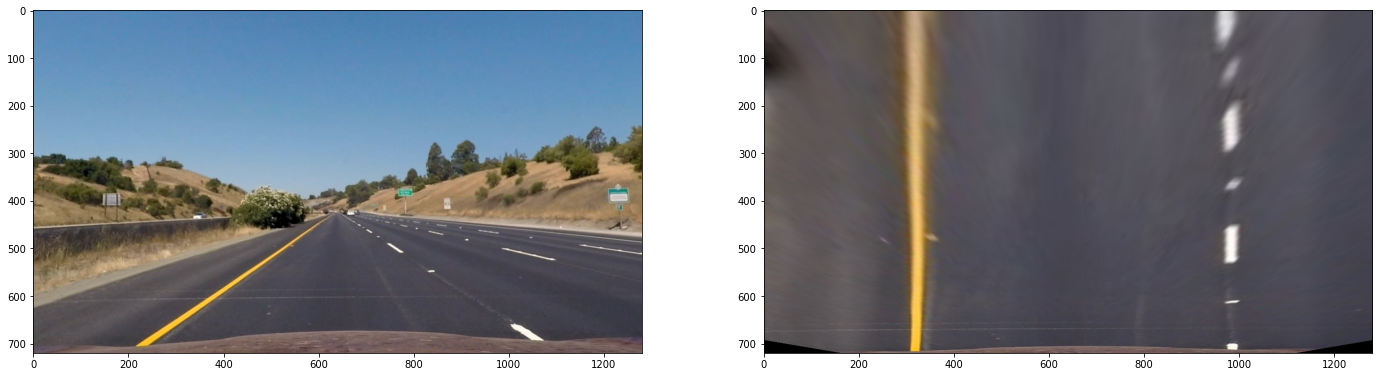

In [6]:
def get_warp_matrix(image_size=(1280, 720), 
                    top_y=450, 
                    top_width=105, 
                    bottom_width=1050, 
                    dst_offset=250):
    
    """
    Sets up and returns the warp matrix for the birds eye view. 
    The assumption is that an isosceles trapzoid will be warped
    into a rectangle. The trapezoid is centered on the image. The 
    input parameters top_y, top_width, and bottom_width define the 
    trapezoid. 
    The default values for the input parameters were determined by
    checking multiple images of the straight roads. 
    
    The function returns the source and destination points used to 
    calculate the warp matrix, the warp matrix, and its inverse.
    """
    
    width, height = image_size
    
    top_left_x = (width - top_width) // 2
    top_right_x = (width + top_width) // 2
    
    bottom_left_x = (width - bottom_width) // 2
    bottom_right_x = (width + bottom_width) // 2
    
    src = np.float32([[bottom_left_x, height], 
                      [bottom_right_x, height], 
                      [top_right_x, top_y], 
                      [top_left_x, top_y]])
    
    dst = np.float32([[dst_offset, height], 
                      [width - dst_offset, height], 
                      [width - dst_offset, 0], 
                      [dst_offset, 0]])
    
    warp_matrix = cv2.getPerspectiveTransform(src, dst)
    warp_matrix_inv = np.linalg.inv(warp_matrix)
    
    return src, dst, warp_matrix, warp_matrix_inv

    
def rectify(image, warp_matrix, img_size=(1280, 720)):
    """
    Applies the warp matrix to the image and returns the 
    perspective transformed Image.
    """
    return cv2.warpPerspective(image, warp_matrix, img_size, flags=cv2.INTER_LINEAR)


image = plt.imread(fnames[7])
image_undist = correct_distortion(image, mtx, dist_coeff)

src, dst, warp_matrix, warp_matrix_inv = get_warp_matrix()

plt.imshow(image)
plt.scatter(src[:, 0], src[:, 1])
plt.show

warped1 = rectify(image_undist, warp_matrix)
show_images(image_undist, warped1)



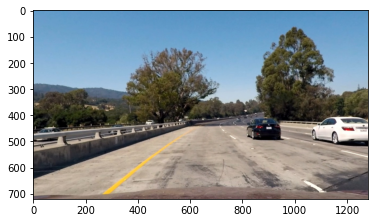

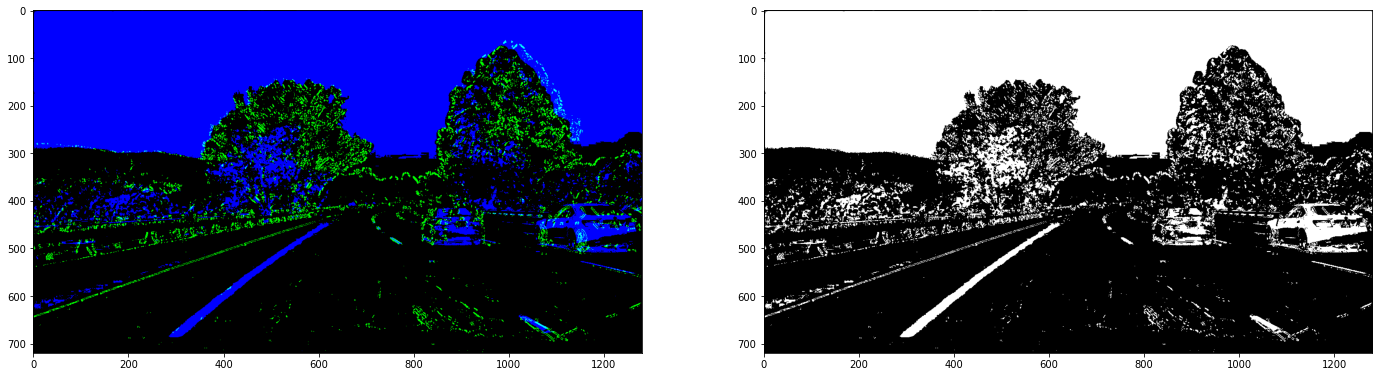

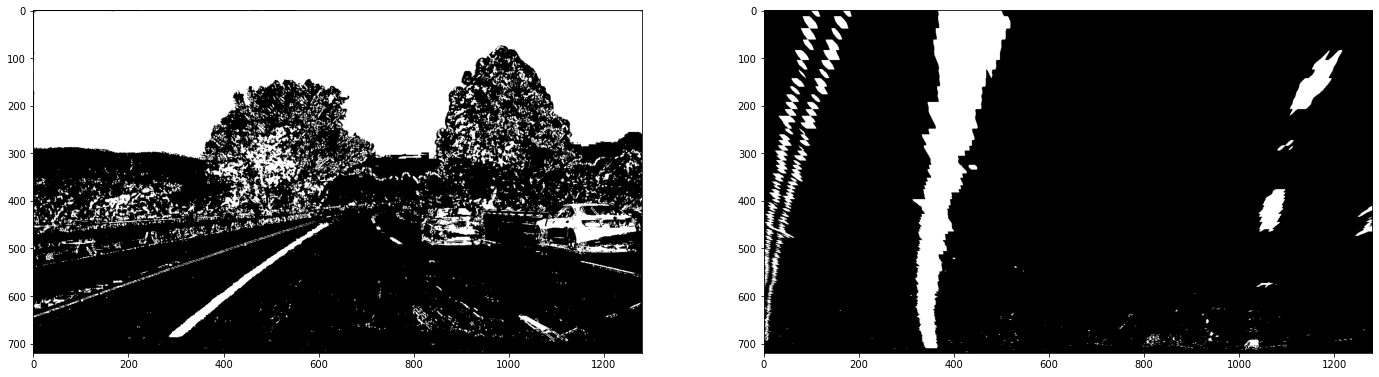

In [7]:

def apply_thresholds(image):
    """
    Applies a different gradient thresholds combined with 
    color threshold on Saturation and returns the resulting
    combined binary image and a combined color image. 
    
    TODO: This function should get different parameters 
    over a dictionary. 
    """
    sx_binary = abs_sobel_threshold(image, direction="x", thresh=(20, 120), ksize=5)
    sy_binary = abs_sobel_threshold(image, direction="y", thresh=(20, 120), ksize=5)
    mag_binary = grad_mag_threshold(image, thresh=(30, 100), ksize=7)
    dir_binary = grad_dir_threshold(image, thresh=(0.2, 0.6), ksize=7)

    combined_grad = np.zeros((image.shape[:2]), np.uint8)
    combined_grad[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    sat_binary = saturation_threshold(image, (100, 255))

    combined_binary = np.zeros_like(sat_binary)
    combined_binary[(combined_grad == 1) | (sat_binary == 1)] = 1

    combined_color = np.dstack((np.zeros_like(combined_grad), combined_grad, sat_binary)) * 255
    
    return combined_binary, combined_color



image = plt.imread(fnames[3])
image_undist = correct_distortion(image, mtx, dist_coeff)
show_image(image_undist)

combined_binary, combined_color = apply_thresholds(image_undist)
show_images(combined_color, combined_binary)


_, _, warp_matrix, warp_matrix_inv = get_warp_matrix()
binary_warped = rectify(combined_binary, warp_matrix)
show_images(combined_binary, binary_warped)



## Detecting Lane Pixels and Fitting a Polynomial




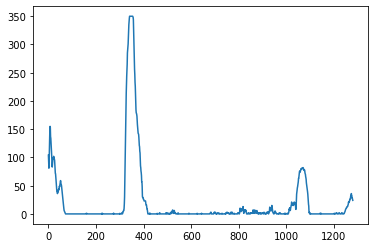

In [8]:
histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
plt.plot(histogram)

### Detecting the Lane Lines

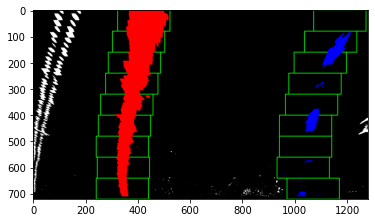

In [9]:
# input: bwarped


def find_lanes_sliding_window(bwarped_img, nwindows=9, margin=100, minpix=50, debug=False):
    """
    Performs a sliding window algorithm on the input binary rectified image
    and returns the (y, x) coordinate of pixels belonging to each left and
    right lanes. Also return the offset of lane midpiont from imge midpoint
    in pixels. 
    
    Args:
        bwarped_img: 
            The binary rectified image of the road (warped to brid eye view).
        nwindows:   
            Number of windows for the sliding window algorithm. 
        margin:      
            Each window has the width 2*margin and is centered around 
            the lane line. (The windows is actually centered around its 
            base which is adjusted to be aligned with the lane line). 
        minpix:     
            If the number of nonzero pixels inside a window is higher than 
            minpix, the x coordinated of the base for the next window is 
            calculated to be the mean of x coordinate of nonzero pixels in 
            current window.
        debug:      
            If True, an image of windows and detected lane pixels overlaid 
            over input image is returned.
            
    Returns: 
        Two arrays, for left lane and for right lane, of shape 
        (n, 2) containing the (y, x) coordinate of each pixel 
        belonging to the lane. 
        
        The pixel value of the offset of the center point of lane 
        from the middle of the image. The center point of lane is 
        the middle point between the x coordinate of the left and
        right lane. The offset value is signed with negative values 
        meaning the center of the lane is to the left of the middle
        point of the image. 
        
        If debug is true, also an image depicting the detected lanes 
        is returned. 
        
    """
    
    # find the x coordinate of the base of left and right lane
    histogram = np.sum(bwarped[bwarped.shape[0] // 2:, :], axis=0)
    midpoint = histogram.shape[0] // 2
    base_left_x = np.argmax(histogram[:midpoint])
    base_right_x = midpoint + np.argmax(histogram[midpoint:])

    # find the offset of the lane center from midpoint of the image
    lane_center = (base_left_x + base_right_x) // 2
    offset_from_middle_of_image =  lane_center - (bwarped.shape[1] // 2)

    # window height for sliding window
    w_height = bwarped.shape[0] // nwindows

    # used for positioning the next window
    current_base_left_x = base_left_x
    current_base_right_x = base_right_x

    left_lane_pixels_list = [] 
    right_lane_pixels_list = []

    if debug:
        out_image = np.dstack((bwarped, bwarped, bwarped))*255
        
    for w in range(nwindows):
        # get the coordinates of the left and right window
        w_bottom_y = bwarped.shape[0] - (w * w_height)
        w_top_y = bwarped.shape[0] - (w + 1) * w_height
        left_w_lx = current_base_left_x - margin 
        left_w_rx = current_base_left_x + margin
        right_w_lx = current_base_right_x - margin
        right_w_rx = current_base_right_x + margin

        if debug:
            # draw widow
            cv2.rectangle(out_image, (left_w_lx, w_top_y), 
                          (left_w_rx, w_bottom_y), (0, 255, 0), 2)
            cv2.rectangle(out_image, (right_w_lx, w_top_y), 
                          (right_w_rx, w_bottom_y), (0, 255, 0), 2)

        # collect the coordinates of nonzero pixels in the window
        left_win = bwarped[w_top_y:w_bottom_y, left_w_lx:left_w_rx]
        right_win = bwarped[w_top_y:w_bottom_y, right_w_lx:right_w_rx]
        
        left_nz = left_win.nonzero()
        left_nzy = left_nz[0] + w_top_y
        left_nzx = left_nz[1] + left_w_lx
        
        right_nz = right_win.nonzero()
        right_nzy = right_nz[0] + w_top_y
        right_nzx = right_nz[1] + right_w_lx
 
        left_lane_pixels_list.append(np.array([left_nzy, left_nzx]).T)
        right_lane_pixels_list.append(np.array([right_nzy, right_nzx]).T)

        # move window horizontally to follow the lane
        if len(left_nzx) > minpix: 
            current_base_left_x = np.int(np.mean(left_nzx))
        if len(right_nzx) > minpix:
            current_base_right_x = np.int(np.mean(right_nzx))

    # create one array containing all lane coordinates for each lane
    left_lane_pixels = np.vstack(left_lane_pixels_list)
    right_lane_pixels = np.vstack(right_lane_pixels_list)

    if debug:    
        # draw detected lane pixels
        out_image[left_lane_pixels[:, 0], left_lane_pixels[:, 1], :] = (255, 0, 0)
        out_image[right_lane_pixels[:, 0], right_lane_pixels[:, 1], :] = (0, 0, 255)

    if debug: 
        return (left_lane_pixels, 
                right_lane_pixels, 
                offset_from_middle_of_image, 
                out_image)
    else:
         return (left_lane_pixels, 
                 right_lane_pixels, 
                 offset_from_middle_of_image)
            

    
bwarped = np.copy(binary_warped)   
left_lane_pixels, right_lane_pixels, \
    offset_from_middle_of_image, \
        out_image = find_lanes_sliding_window(bwarped, debug=True)
show_image(out_image)

### Fitting Polynemial

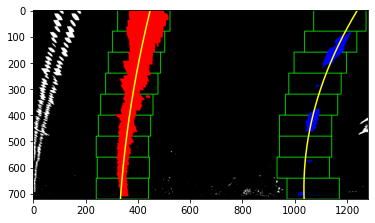

In [10]:
def fit_lane_poly(left_lane_pixels, right_lane_pixels):
    """
    Fits a 2nd degree polynomial of y to the input list of (y, x)
    coordinates for each lane line. The polynomial is fitted for 
    y becuase the lanes are often close to vertical. As a result 
    there might be multiple y values for a given x value. 
    
    Calculates the plot (x,y) coordinates of the polynome for each
    of the lane lines. 
    
    Args:
        left_lane_pixels:
            An array of (y, x) coordinates of all pixesl belonging 
            to the left lane
        right_lane_pixels: 
            An array of (y, x) coordinates of all pixesl belonging 
            to the right lane
 
    Returns: 
        Cooefficents of the fitted 2nd degree polynomial of the left curve. 
        Cooefficents of the fitted 2nd degree polynomial of the right curve. 
        The y coordinates for calculating the x values.
        The calculated x values (by evaluating the polynome for y values) 
        for left lane.
        The calculated x values (by evaluating the polynome for y values) 
        for right lane.
    """
    
    lefty, leftx = np.split(left_lane_pixels, 2, axis=1)
    righty, rightx = np.split(right_lane_pixels, 2, axis=1)
    
    left_fit = [1, 1, 0]
    right_fit = [1, 1, 0]
    try: 
        left_fit = np.polyfit(lefty.squeeze(), leftx.squeeze(), 2)
        right_fit = np.polyfit(righty.squeeze(), rightx.squeeze(), 2)
    except TypeError: 
        print("Error: Could not fit the curve.")
    
    plotys = np.linspace(0, bwarped.shape[0] - 1, bwarped.shape[0])
    plotleftxs = np.polyval(left_fit, plotys)
    plotrightxs = np.polyval(right_fit, plotys)
    
    return left_fit, right_fit, plotys, plotleftxs, plotrightxs
    
    
left_fit_pix, right_fit_pix, \
    plotys, plotleftxs, plotrightxs = \
        fit_lane_poly(left_lane_pixels, right_lane_pixels)

plt.imshow(out_image)
plt.plot(plotleftxs, plotys, color="yellow")
plt.plot(plotrightxs, plotys, color="yellow")


### Determining the Curvature

$$ \LARGE R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|} $$

$$ \LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left |2A \right |} $$

In [17]:




def eval_lane_curvature(left_fit, right_fit, yeval, my=30/720, mx=3.7/780):
    """
    Calculates the radius of the curvature at `yeval` point using the 
    lane curve polynomials: (ay^2 + by + c). 
    
    The my and mx scale factors are used to convert the values from 
    pixel space to meter space. The radius of the curvature is calculated
    as the avrage from the radii of the left and right curves. 
    
    The function returns the radius of left and right curvatures in meters and the 
    direction of the curve (left or right). 
    
    Args:
        left_fit: 
            Coefficients of the left lane curve.
        right_fit:
            Coefficients of the right lane curve
        yeval: 
            The radius of the curvature is calcuted at yeval point
        my:
            The pixel to meter scale factor for y direction in 
            meter per pixel units. The default value assumes 
            30 meters of the road are depicted in a 720 pixel 
            high rectified image. 
        mx:
            The pixel to meter scale factor for x direction in 
            meter per pixel units. The default value assumes 
            3.7 meters of the road are depicted in a 780 pixels 
            of the the rectified image. 
    """
    yeval_m = my * yeval

    # Convert the values of coefficients form pixel 
    # to meter using scale factor.
    l_a_pix = left_fit[0]
    l_a_m = (mx / my**2) * l_a_pix
    l_b_pix = left_fit[1]
    l_b_m = (mx/my) * l_b_pix
    l_c_pix = left_fit[2]
    l_curv_m = np.power((1 + (l_a_m * yeval_m + l_b_m)**2), 1.5) / np.absolute(2 * l_a_m)
   
    r_a_pix = right_fit[0]
    r_a_m = (mx / my**2) * r_a_pix
    r_b_pix = right_fit[1]
    r_b_m = (mx/my) * r_b_pix
    r_c_pix = right_fit[2]
    r_curv_m = np.power((1 + (2 * r_a_m * yeval_m + r_b_m)**2), 1.5) / np.absolute(2 * r_a_m)
    
    # the curve is to the left if the a coefficient is positive
    curve_direction = CurveDirection.RIGHT if l_a_pix > 0 else CurveDirection.LEFT
    if np.average((l_curv_m, r_curv_m)) > 5000: curve_direction = CurveDirection.STRAIGHT_ROAD
    
    return l_curv_m, r_curv_m, curve_direction
    

def eval_vehicle_offset(pixel_offset, mx=3.7/780):
    """
    Calculates offset of the vehicle from middle of the lane 
    based on the value of the pixel offset of center of the 
    detected lane from middle of the camera image. 
    The vehicle offset is calculated in meters using the scale
    factor mx (in meters per pixel). The default scale factor mx 
    assumes the lane width is 3.7 and it is depicted in 780 pixels 
    of the rectified image of the road. 
    
    Returns:
        Offset of the vehicle from middle of the lane. The offset
        is a signed float. Negative offset means drift to the left, 
        positive offset means drift to the right.
        The direction of the offset is also returned. 
    """
    offset_direction = "right" if pixel_offset > 0 else "left"
    vehicle_offset = mx * pixel_offset
    return vehicle_offset, offset_direction
    

yeval = np.max(plotys)
l_radius, r_radius, c_direction = eval_lane_curvature(left_fit_pix, right_fit_pix, yeval)
print("Left lane curvature: ", l_radius)
print("Right lane curvature: ", r_radius)
print(c_direction)
print("\n")

vehicle_offset, offset_direction = eval_vehicle_offset(offset_from_middle_of_image)
print("Offset in pixels: ", offset_from_middle_of_image)
print(f"Vehicle is {abs(vehicle_offset):2.2f}m {offset_direction} of the lane center.")


Left lane curvature:  25738.679015227386
Right lane curvature:  2635.0100610409904
CurveDirection.STRAIGHT_ROAD


Offset in pixels:  15
Vehicle is 0.07m right of the lane center.


## Warping Detected Lanes Back to the Image

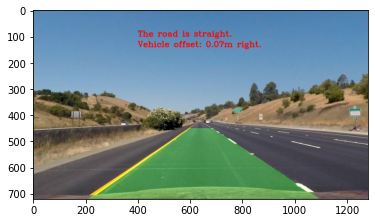

In [37]:
def visualize_lane(undist_img, bwarped_img_shape, 
                   warp_matrix_inv, ys, 
                   left_curve_xs, right_curve_xs, 
                   color=(0, 255, 0)):
    """
    Returns the input unidstored image with the detected 
    lane overlaid on it. 
    
    The lane is first drawn on an image with the same shape
    as the binary warped image. The y and x coordinates of 
    left and right curves are used to fill the lane polygon. 
    The image is then warped back using inverse of the warp 
    matrix and is overlayed on the undistorted image. 
    
    Args: 
        undist_img:
            The undistored image of the road to darw the lane on. 
        bwarped_img_shape:
            The shape of the binary warped image used for detecting
            the lane lines. 
        warp_matrix_inv:
            The inverse of the warp matrix used for rectifying the road
            image
        ys:
            The y coordinates of the curves in the binary warped image.
        left_curve_xs:
            The x coordinates of the left cruve in the binary warped image.
        right_curve_xs: 
            The x coordinates of the right curve in the binary warped image. 
        color: 
            The color to draw the lane. Defualt is green.
            
    Returns: 
        Undistored image overlayed with the detected lane. 
        
    """
    warp_zero = np.zeros(bwarped_img_shape, dtype=np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_curve_xs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_curve_xs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_(pts), color)

    unwarp = cv2.warpPerspective(color_warp, warp_matrix_inv, (undist_img.shape[1], undist_img.shape[0]))
    return cv2.addWeighted(undist_img, 1., unwarp, 0.3, 0)


def visualize_info(img, l_radius, r_radius, c_direction, 
                   vehicle_offset, offset_direction):
    """
    Add the road information to img. 
    """
    radius_text = "--"
    avg_radius = (l_radius + r_radius) // 2
    direction = "Left" if c_direction == CurveDirection.LEFT else "Right"
    if c_direction != CurveDirection.STRAIGHT_ROAD:   
        radius_text = f"{direction} curve with radius of {int(avg_radius)}m."
    else:
        radius_text = "The road is straight."
        
    offset_text = f"Vehicle offset: {abs(vehicle_offset):2.2f}m {offset_direction}."
    img = cv2.putText(img, radius_text, (400, 100), cv2.FONT_HERSHEY_COMPLEX, 1.0, (255,0,0), 2) 
    img = cv2.putText(img, offset_text, (400, 140), cv2.FONT_HERSHEY_COMPLEX, 1.0, (255,0,0), 2) 
    return img

undist = correct_distortion(image, mtx, dist_coeff)
result = visualize_lane(undist, bwarped.shape, 
                        warp_matrix_inv, plotys, 
                        plotleftxs, plotrightxs)
result = visualize_info(result, l_radius, r_radius, c_direction, 
                            vehicle_offset, offset_direction)
show_image(result)


## Complete Pipeline



Camera matrix: 
 [[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients: 
 [[-0.24688775 -0.02373132 -0.00109842  0.00035108 -0.00258571]]
------------------------

Left lane curvature:  1031.639040475188
Right lane curvature:  1022.7064351050843
CurveDirection.RIGHT
Vehicle is 0.38m right of the lane center.


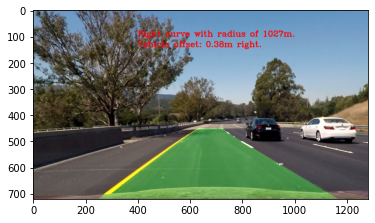

Left lane curvature:  358.0103522290298
Right lane curvature:  162.6881531301518
CurveDirection.RIGHT
Vehicle is 0.08m right of the lane center.


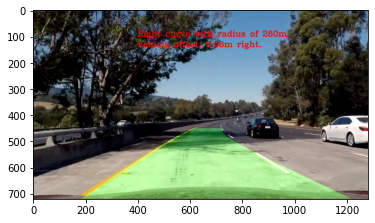

Left lane curvature:  1176.997210465799
Right lane curvature:  683.255271829424
CurveDirection.RIGHT
Vehicle is 0.31m right of the lane center.


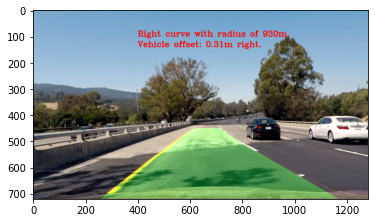

Left lane curvature:  1504.3785299513743
Right lane curvature:  416.3249691548212
CurveDirection.RIGHT
Vehicle is 0.31m right of the lane center.


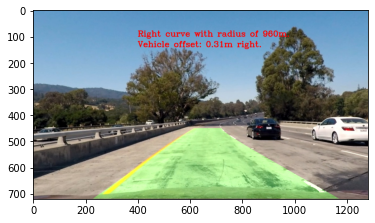

Left lane curvature:  559.7789358970638
Right lane curvature:  598.7162145861515
CurveDirection.RIGHT
Vehicle is 0.30m right of the lane center.


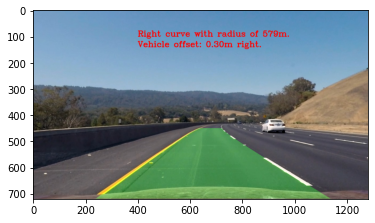

Left lane curvature:  388.6531515662197
Right lane curvature:  356.52933279931085
CurveDirection.LEFT
Vehicle is 0.27m right of the lane center.


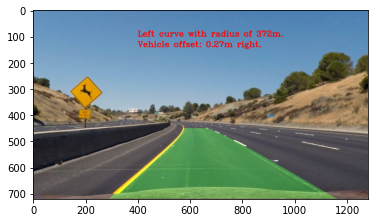

Left lane curvature:  9765.721507344364
Right lane curvature:  3063.3286712817544
CurveDirection.STRAIGHT_ROAD
Vehicle is 0.09m right of the lane center.


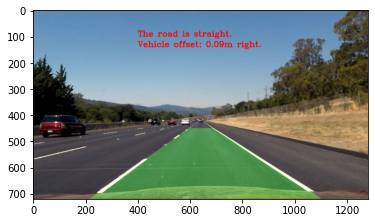

Left lane curvature:  25738.679015227386
Right lane curvature:  2635.0100610409904
CurveDirection.STRAIGHT_ROAD
Vehicle is 0.07m right of the lane center.


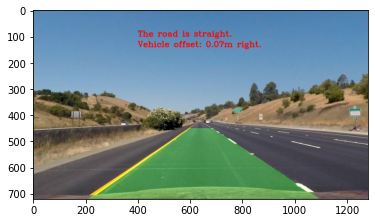

In [38]:
# Camera Calibration
images_path = "./camera_cal/calibration*.jpg"
pattern_size = (9, 6)
mtx, dist_coeff = camera_calibration(images_path, pattern_size)
print("Camera matrix: \n", mtx)
print("Distortion coefficients: \n", dist_coeff)
print("------------------------\n")

# Prepare perspective transform matrix
src, dst, warp_matrix, warp_matrix_inv = get_warp_matrix()

# For each image in test images: 
#   - correct distortion
#   - apply gradient and color threshold
#   - rectify image
#   - detect lane pixels and fit polynomial
#   - determine curvature and offset
#   - warp back detected lane onto the image
#   - output lane cruvature and vehicle offset

fnames = glob.glob("./test_images/*.jpg")
for i, fname in enumerate(fnames):
    image = plt.imread(fname)
    image_undist = correct_distortion(image, mtx, dist_coeff)
    combined_binary, _ = apply_thresholds(image_undist)
    bwarped = rectify(combined_binary, warp_matrix)
    left_lane_pixels, right_lane_pixels, \
        offset_from_middle_of_image = find_lanes_sliding_window(bwarped)
    left_fit_pix, right_fit_pix, \
        plotys, plotleftxs, plotrightxs = \
            fit_lane_poly(left_lane_pixels, right_lane_pixels)
    yeval = np.max(plotys)
    l_radius, r_radius, c_direction = eval_lane_curvature(left_fit_pix, right_fit_pix, yeval)
    print("Left lane curvature: ", l_radius)
    print("Right lane curvature: ", r_radius)
    print(c_direction)
    vehicle_offset, offset_direction = eval_vehicle_offset(offset_from_middle_of_image)
    # print("Offset in pixels: ", offset_from_middle_of_image)
    print(f"Vehicle is {abs(vehicle_offset):2.2f}m {offset_direction} of the lane center.")
    result = visualize_lane(image_undist, bwarped.shape, 
                        warp_matrix_inv, plotys, 
                        plotleftxs, plotrightxs)
    result = visualize_info(result, l_radius, r_radius, c_direction, 
                            vehicle_offset, offset_direction)
    show_image(result)
    

## Pipeline on Video

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    image_undist = correct_distortion(image, mtx, dist_coeff)
    combined_binary, _ = apply_thresholds(image_undist)
    bwarped = rectify(combined_binary, warp_matrix)
    left_lane_pixels, right_lane_pixels, \
        offset_from_middle_of_image = find_lanes_sliding_window(bwarped)
    left_fit_pix, right_fit_pix, \
        plotys, plotleftxs, plotrightxs = \
            fit_lane_poly(left_lane_pixels, right_lane_pixels)
    yeval = np.max(plotys)
    l_radius, r_radius, c_direction = eval_lane_curvature(left_fit_pix, right_fit_pix, yeval)
    print("Left lane curvature: ", l_radius)
    print("Right lane curvature: ", r_radius)
    print(c_direction)
    vehicle_offset, offset_direction = eval_vehicle_offset(offset_from_middle_of_image)
    # print("Offset in pixels: ", offset_from_middle_of_image)
    print(f"Vehicle is {abs(vehicle_offset):2.2f}m {offset_direction} of the lane center.")
    result = visualize_lane(image_undist, bwarped.shape, 
                        warp_matrix_inv, plotys, 
                        plotleftxs, plotrightxs)
    result = visualize_info(result, l_radius, r_radius, c_direction, 
                            vehicle_offset, offset_direction)
    return result



    

<br>

## Notes and Schmierpapier

In [ ]:
np.mgrid[0:3, 0:4].T.reshape(-1)

In [ ]:
data1, data2, data3, data4 = np.random.randn(4, 100)

In [ ]:

image = mpimg.imread(fnames[7])
pts = np.array([[330,620],[950,620],[692,450],[587,450]])
plt.imshow(image)
plt.plot(640, 570, "og", markersize=10)
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)
plt.show()

In [ ]:
binary = np.random.randint(2, size=(4,5))
print(binary)
print("\n----------\n")


fig, ax = plt.subplots()
ax.set_yticks(np.arange(5))
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.imshow(binary)


In [ ]:
nonzeros = binary.nonzero()
nzy, nzx = nonzeros
nzx

In [ ]:
a = np.array([nzy, nzx])
a

In [ ]:
b = a.T
b

In [ ]:
ys, xs = np.split(b, 2, axis=1)
ys.squeeze().shape

In [ ]:
a = np.empty((0, 2))
b = np.array([[1, 2], [2, 3]])
c = np.arange(12).reshape((-1, 2))

In [ ]:
a = np.vstack((a, b))

In [ ]:
d = np.vstack((a, c))

In [ ]:
d

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(bwarped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([plotleftxs, plotys]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([plotrightxs, plotys])))])
pts = np.hstack((pts_left, pts_right))
print(pts.shape)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

show_image(color_warp)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
undist = correct_distortion(image, mtx, dist_coeff)
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [ ]:
bwarped_img_shape = (720, 1280)
